In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from multiprocessing import Pool
from functools import partial

import MicroTools as micro
import MicroTools.plot_tools as pt

import MicroTools.param_scan as param_scan
from tqdm.notebook import tqdm

import MH_decay_scan_run

import matplotlib.animation
from matplotlib.animation import FuncAnimation

# Context

variable numbers are as follows:


- 0 - gphi
- 1 - deltam^2
- 2 - |Ue4|^2
- 3 - |Umu4|^2
- 4 - sin^2(2 thetaemu) (doesn't always make sense to use)

The scan file names also follow a pattern. "2D", "3D", "4D" indicate how many parameters were scanned over. Usually the ones left fixed appear in the filename.

Some gifs may be using outdated fits...

In [17]:
labels_slices = [r'$g_\varphi$',r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', r"$|U_{e 4}|^2$", r"$|U_{\mu 4}|^2$", r"$\sin^2(2\theta_{\mu e})$"]
string_slices = [r'$g_\varphi$',r'$\Delta m_{41}^2$', r"$|U_{e 4}|^2$", r"$|U_{\mu 4}|^2$", r"$\sin^2(2\theta_{\mu e})$"]
def get_var(data, i):
    if i == 1:
        return data[:,1]**2
    return data[:,i]

### GIFs

In [12]:
# Your existing function with a few modifications
def make_gif(filename, xi=2, yi=3, zi=1, z_range=None, wi=0, w_fixed=1, frames = 10, global_deltachi2=False, osc=False, plot_Asimov=True, microColor='darkorange', microColor_2='grey', cmap_color='steelblue', n_sigmas=4, cmin=0.05, cmax=0.95):
    data = param_scan.pickle_read(f"fit_data/{filename}.pkl")
    cut_in_w = data[np.argmin(np.abs(data[:,wi] - w_fixed)), wi]
    data = data[(data[:,wi] == cut_in_w)]

    MiniApp_chi2, MicroApp_chi2, MicroApp_Asimov_chi2 = data[:,-3], data[:,-2], data[:,-1] 
    
    x, y, z, w = get_var(data,xi), get_var(data,yi), get_var(data,zi), get_var(data, wi)
    i_min = np.argmin(MiniApp_chi2)
    x_min, y_min, z_min = x[i_min], y[i_min], z[i_min]
    if len(np.unique(z)) < frames:
        print("Adjusting number of frames to match number of unique z values")
        frames = len(np.unique(z))
    if z_range is not None:
        z_slices = np.geomspace(z_range[0], z_range[1], frames,endpoint=True)
    else:
        z_slices = np.geomspace(np.min(z), np.max(z), frames, endpoint=True)

    if z_min not in z_slices:
        z_slices = np.delete(z_slices, np.argmin(np.abs(z_slices - z_min)))
        z_slices = np.append(z_slices, z_min)
    z_slices = np.sort(z_slices)
    
    fig, ax = pt.std_fig(figsize=(4, 4), ax_form=pt.std_axes_form)
    # Create a function to update the plot for each frame
    def update(frame):
        ax.clear()
        z_slice = z_slices[frame]
        z_slice_true = z[np.argmin(np.abs(z - z_slice))]
        cut = (z == z_slice_true)
        
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.tick_params(axis="both", which='both', direction="inout", left="off", labelleft="on", zorder=10)

        ax.set_xlim(x.min(), x.max())
        ax.set_ylim(y.min(), y.max())
        ax.set_ylabel(string_slices[yi], fontproperties=pt.font, fontsize=10)    
        ax.set_xlabel(string_slices[xi], fontproperties=pt.font, fontsize=10)

        fixed_value = fr"{string_slices[zi]} \,$= {pt.sci_notation(z_slice_true, sig_digits=1, notex=True, optional_sci=3)}$"
        if zi == 1:
            fixed_value += r"\, eV$^2$"

        kwargs_interp = {   'fine_gridx': len(np.unique(x)),  
                            'fine_gridy': len(np.unique(y)), 
                            'logx':True, 
                            'logy':True,
                            'method': 'interpolate',

                        }

        if global_deltachi2:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MiniApp_chi2[cut]-np.min(MiniApp_chi2), **kwargs_interp)
            ndof = 3
        else:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MiniApp_chi2[cut]-np.min(MiniApp_chi2[cut]), **kwargs_interp)
            ndof = 2
        
        colors = pt.get_cmap_colors(cmap_color, n_sigmas, cmin=cmin, cmax=cmax)
        cs = ax.contourf(X,Y,Z, levels=pt.get_chi2vals_w_nsigmas(n_sigmas, ndof), colors=colors, zorder=1, alpha=1)
        cs = ax.contour(X,Y,Z, levels=pt.get_chi2vals_w_nsigmas(n_sigmas, ndof), colors=['black','black','black'], linewidths=0.5, zorder=1, alpha=1)
        ax.scatter(X.flatten()[np.nanargmin(Z)], Y.flatten()[np.nanargmin(Z)], marker='*', facecolor='white', edgecolor='black', lw=0.5, zorder=10)

        if global_deltachi2:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MicroApp_chi2[cut] - np.min(MicroApp_chi2), **kwargs_interp)
        else:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MicroApp_chi2[cut] - np.min(MicroApp_chi2[cut]), **kwargs_interp)
        # cs = ax.contour(X,Y,Z, levels=pt.get_chi2vals_w_CL([0.95], ndof), colors=['black'], linestyles=[(1,(3,1))], zorder=2)
        cs = ax.contour(X,Y,Z, levels=[pt.get_chi2vals_w_sigma(2,ndof),pt.get_chi2vals_w_sigma(3,ndof)], colors=[microColor,microColor], zorder=2, linewidths=1.5, linestyles=['-', (1,(3,0.5))])

        # if global_deltachi2:
        #     X, Y, Z = pt.interp_grid(x[cut], y[cut], MicroApp_Asimov_chi2[cut] - np.min(MicroApp_Asimov_chi2), **kwargs_interp)
        # else:
        #     X, Y, Z = pt.interp_grid(x[cut], y[cut], MicroApp_Asimov_chi2[cut] - np.min(MicroApp_Asimov_chi2[cut]), **kwargs_interp)


        if z_min == z_slice:
            ax.scatter(x_min, y_min, marker='*', facecolor='black', edgecolor='black', lw=0.25, zorder=10)

        ax.plot([], [], color=microColor, lw=1.5, label='$\mu$B 2$\sigma$')
        ax.plot([], [], color=microColor, lw=1.5, ls=(1,(3,0.5)), label='$\mu$B 3$\sigma$')
        h, l = ax.get_legend_handles_labels()
        h.append(pt.MulticolorPatch(colors))
        mb_label = 'MB '+', '.join([fr'${i+1} \sigma$' for i in range(n_sigmas)])
        l.append(mb_label)
        ax.legend(h, l, loc=(0,0), fontsize=9, handler_map={pt.MulticolorPatch: pt.MulticolorPatchHandler()})

        nstring = r'n_{\rm dof}'
        if osc:
            ndof = rf'${nstring} = {ndof}$'
            ax.annotate(text=fr"{ndof} $\vert$ {fixed_value}", xycoords='axes fraction', xy=(0.5,1.025), fontsize=10, ha='center', zorder=10)
        else:
            ndof = rf' $\vert$ ${nstring} = {ndof}$'
            ax.annotate(text=fr"{string_slices[wi]} $\,= {w_fixed:.2f}${ndof} $\vert$ {fixed_value}", xycoords='axes fraction', xy=(0.5,1.025), fontsize=10, ha='center', zorder=10)

        # Return a tuple of the artists that have been updated. This tells the animation framework what parts of the plot should be animated.
        return (cs,)

    # Create the animation object. This will animate the 'update' function across the frames of your z_slices.
    anim = FuncAnimation(fig, update, frames=frames, blit=True)

    # Save the animation to a file
    anim.save(f"{micro.path_plots}/MH_gif_{xi}_{yi}_{zi}_{wi}_{w_fixed:.3f}{'_global' if global_deltachi2 else ''}.gif", writer='Pillow', fps=5, dpi=300)  

In [13]:
CMAP = 'steelblue'
microColor='black'
microColor_2 = 'darkorange'
kwargs = {'plot_Asimov': False, 'microColor': microColor, 'microColor_2': microColor_2, 'cmap_color': CMAP, 'n_sigmas': 4, 'cmin': 0.2, 'cmax': 1}

MovieWriter Pillow unavailable; using Pillow instead.


Adjusting number of frames to match number of unique z values


MovieWriter Pillow unavailable; using Pillow instead.


Adjusting number of frames to match number of unique z values


MovieWriter Pillow unavailable; using Pillow instead.


Adjusting number of frames to match number of unique z values


MovieWriter Pillow unavailable; using Pillow instead.


Adjusting number of frames to match number of unique z values


MovieWriter Pillow unavailable; using Pillow instead.


Adjusting number of frames to match number of unique z values


MovieWriter Pillow unavailable; using Pillow instead.


Adjusting number of frames to match number of unique z values


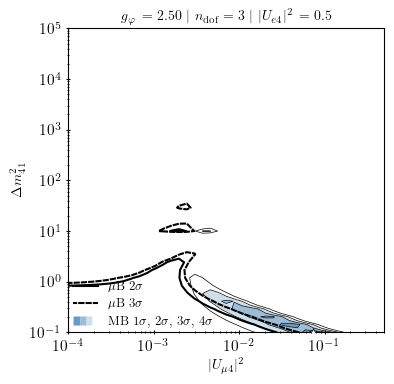

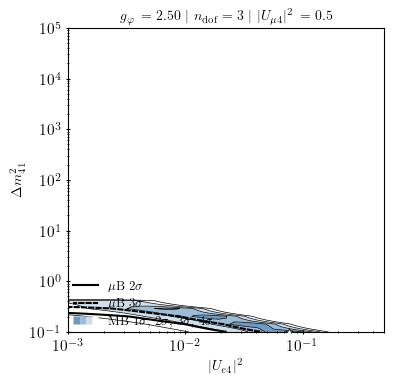

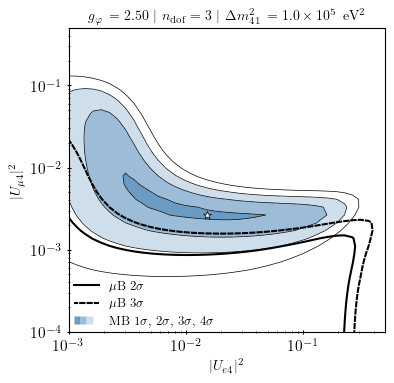

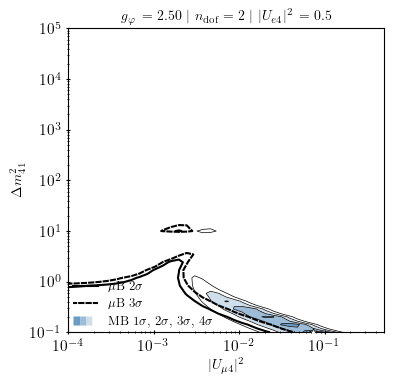

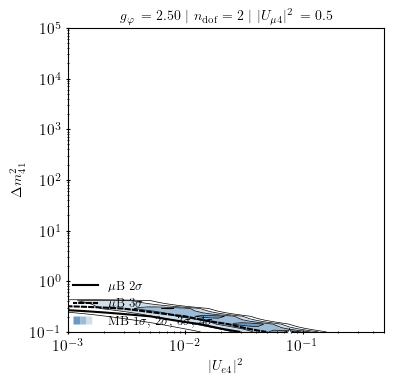

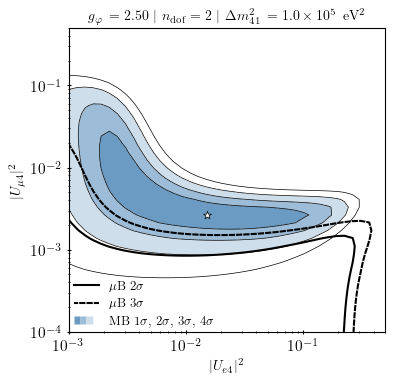

In [9]:
make_gif('MH_decay_gfixed_2.5_3D_40', xi=3, yi=1, zi=2, wi=0, w_fixed=2.5, global_deltachi2=True, frames=60, **kwargs)
make_gif('MH_decay_gfixed_2.5_3D_40', xi=2, yi=1, zi=3, wi=0, w_fixed=2.5, global_deltachi2=True, frames=60, **kwargs)
make_gif('MH_decay_gfixed_2.5_3D_40', xi=2, yi=3, zi=1, wi=0, w_fixed=2.5, global_deltachi2=True, frames=60, **kwargs)


make_gif('MH_decay_gfixed_2.5_3D_40', xi=3, yi=1, zi=2, wi=0, w_fixed=2.5, global_deltachi2=False, frames=60, **kwargs)
make_gif('MH_decay_gfixed_2.5_3D_40', xi=2, yi=1, zi=3, wi=0, w_fixed=2.5, global_deltachi2=False, frames=60, **kwargs)
make_gif('MH_decay_gfixed_2.5_3D_40', xi=2, yi=3, zi=1, wi=0, w_fixed=2.5, global_deltachi2=False, frames=60, **kwargs)

MovieWriter Pillow unavailable; using Pillow instead.


Adjusting number of frames to match number of unique z values


MovieWriter Pillow unavailable; using Pillow instead.


Adjusting number of frames to match number of unique z values


MovieWriter Pillow unavailable; using Pillow instead.


Adjusting number of frames to match number of unique z values


MovieWriter Pillow unavailable; using Pillow instead.


Adjusting number of frames to match number of unique z values


MovieWriter Pillow unavailable; using Pillow instead.


Adjusting number of frames to match number of unique z values


MovieWriter Pillow unavailable; using Pillow instead.


Adjusting number of frames to match number of unique z values


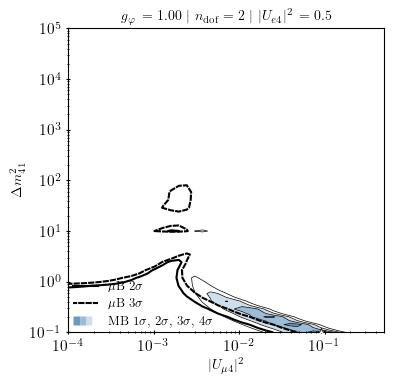

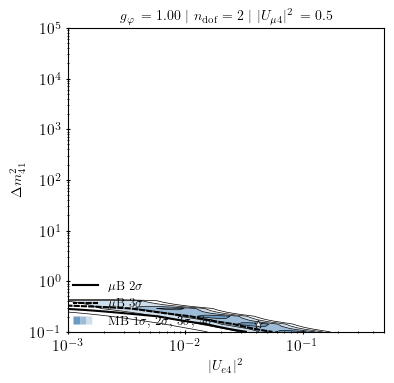

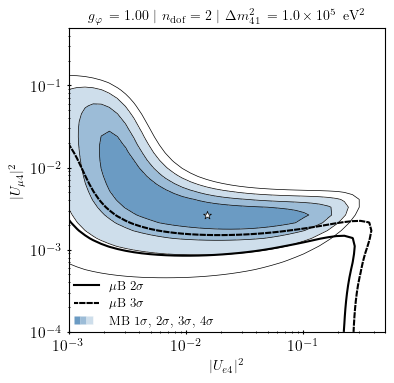

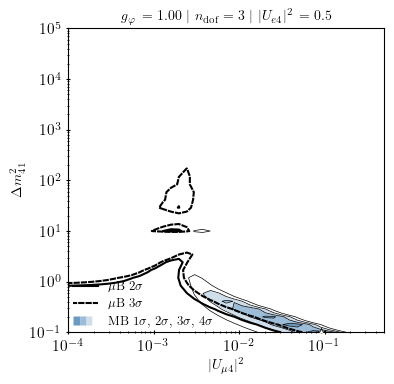

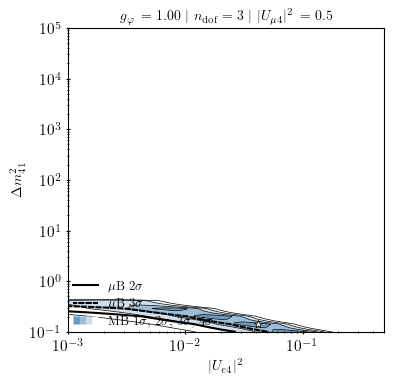

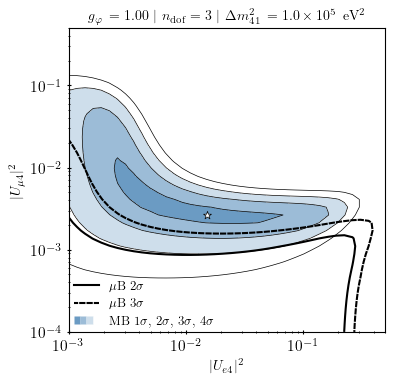

In [14]:
make_gif('MH_decay_gfixed_1.0_3D_40', xi=3, yi=1, zi=2, wi=0, w_fixed=1.0, global_deltachi2=False, frames=60, **kwargs)
make_gif('MH_decay_gfixed_1.0_3D_40', xi=2, yi=1, zi=3, wi=0, w_fixed=1.0, global_deltachi2=False, frames=60, **kwargs)
make_gif('MH_decay_gfixed_1.0_3D_40', xi=2, yi=3, zi=1, wi=0, w_fixed=1.0, global_deltachi2=False, frames=60, **kwargs)

make_gif('MH_decay_gfixed_1.0_3D_40', xi=3, yi=1, zi=2, wi=0, w_fixed=1.0, global_deltachi2=True, frames=60, **kwargs)
make_gif('MH_decay_gfixed_1.0_3D_40', xi=2, yi=1, zi=3, wi=0, w_fixed=1.0, global_deltachi2=True, frames=60, **kwargs)
make_gif('MH_decay_gfixed_1.0_3D_40', xi=2, yi=3, zi=1, wi=0, w_fixed=1.0, global_deltachi2=True, frames=60, **kwargs)

MovieWriter Pillow unavailable; using Pillow instead.


Adjusting number of frames to match number of unique z values


MovieWriter Pillow unavailable; using Pillow instead.


Adjusting number of frames to match number of unique z values


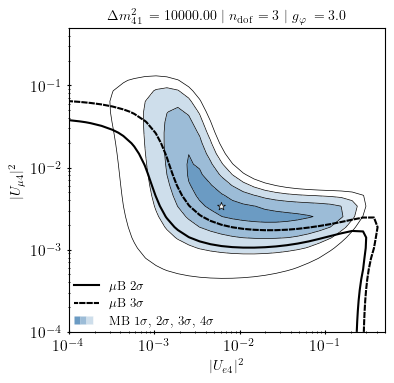

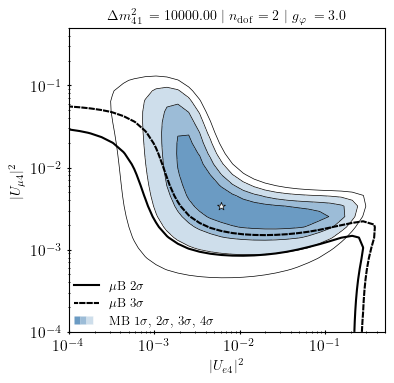

In [15]:
make_gif('MH_decay_4D_30', xi=2, yi=3, zi=0, wi=1, w_fixed=1e4, global_deltachi2=True, frames=60, **kwargs)
make_gif('MH_decay_4D_30', xi=2, yi=3, zi=0, wi=1, w_fixed=1e4, global_deltachi2=False, frames=60, **kwargs)

MovieWriter Pillow unavailable; using Pillow instead.


Adjusting number of frames to match number of unique z values


MovieWriter Pillow unavailable; using Pillow instead.


Adjusting number of frames to match number of unique z values


MovieWriter Pillow unavailable; using Pillow instead.


Adjusting number of frames to match number of unique z values


MovieWriter Pillow unavailable; using Pillow instead.


Adjusting number of frames to match number of unique z values


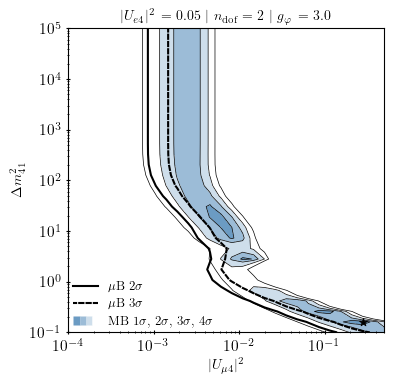

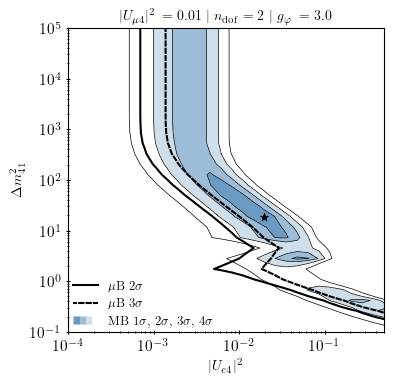

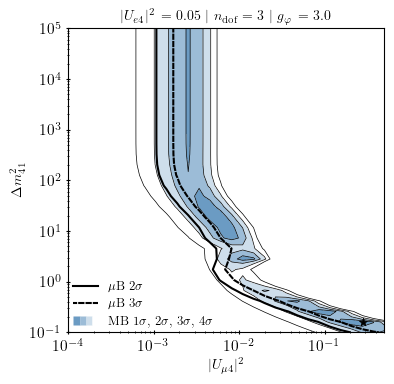

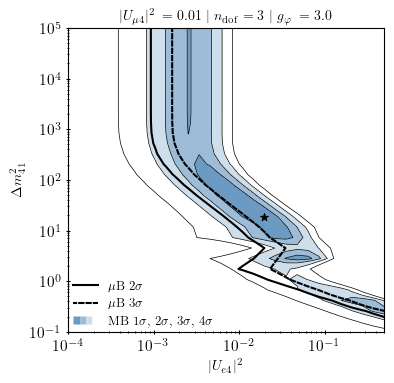

In [18]:
make_gif('MH_decay_4D_30', xi=3, yi=1, zi=0, wi=2, w_fixed=0.05, global_deltachi2=False, frames=60, **kwargs)
make_gif('MH_decay_4D_30', xi=2, yi=1, zi=0, wi=3, w_fixed=0.01, global_deltachi2=False, frames=60, **kwargs)

make_gif('MH_decay_4D_30', xi=3, yi=1, zi=0, wi=2, w_fixed=0.05, global_deltachi2=True, frames=60, **kwargs)
make_gif('MH_decay_4D_30', xi=2, yi=1, zi=0, wi=3, w_fixed=0.01, global_deltachi2=True, frames=60, **kwargs)